In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
arc_data = Table.read('fits/arc_table_all.fits')
ml_table_matched = Table.read('fits/ml_table_matched.fits')
gz2_stats = Table.read('fits/gz2_statistics.fits')
mendel_data = Table.read('fits/mendel_matched.fits')

#### First task: define the sample:

In [5]:
def measure_N_detected(ids,arc_data):
    N_good = []
    pitch_angles = []
    for id_ in ids:
        arc_row_mask = arc_data['gxyName'] == id_
        N_total_id = arc_row_mask.sum()
        if N_total_id > 0:
            arcs_id = arc_data[arc_row_mask]
            good_arcs = arcs_id['p_good_predicted'] == 1
            N_good_id = good_arcs.sum()
            if N_good_id > 0:
                length_weights = arcs_id['arc_length'][good_arcs]
                Ps = arcs_id['pitch_angle_absolute'][good_arcs]
                pitch_angle = np.average(Ps,weights=length_weights)
            else:
                pitch_angle = -999
            
            N_good.append(N_good_id)
            pitch_angles.append(pitch_angle)
        else:
            N_good.append(-999)
            pitch_angles.append(-999)
    
    return np.array(N_good), np.array(pitch_angles)


in_ml = ml_table_matched['vmax_ok']
print('{} galaxies in ML sample'.format(in_ml.sum()))
ml_dr8ids = gz2_data['dr8objid'][in_ml]

Ns, psis = measure_N_detected(ml_dr8ids,arc_data)

galaxy_level_data = Table()
galaxy_level_data['dr8objid'] = ml_dr8ids
galaxy_level_data['dr7objid'] = gz2_data['dr7objid'][in_ml]
galaxy_level_data['N_arcs'] = Ns
galaxy_level_data['P_wtd_avg'] = psis

6222 galaxies in ML sample


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.


In [15]:
from bin_statistics import assign_bins, TableStats
mlabels = ('1','2','3','4','5+')

in_sparcfire = galaxy_level_data['N_arcs'] >= 0
#x = galaxy_level_data['N_arcs'][in_sparcfire]
bins = gz2_stats['m'][in_ml][in_sparcfire]
has_arcs = galaxy_level_data['N_arcs'][in_sparcfire] > 0

f_sparcfire = TableStats(has_arcs,bins).fraction_with_feature()

In [17]:
from combining_catalogues import match_ids, make_matched_catalogue

ids_ = match_ids(gz2_data,galaxy_level_data,'dr7objid','dr7objid')
galaxy_level_matched = make_matched_catalogue(gz2_data,galaxy_level_data,
                                              ids_)
galaxy_level_matched['dr7objid'] = gz2_data['dr7objid']
galaxy_level_matched['dr8objid'] = gz2_data['dr8objid']

galaxy_level_data.write('fits/galaxy_level_data.fits',overwrite=True)
galaxy_level_matched.write('fits/galaxy_level_matched.fits',overwrite=True)

INFO:astropy:Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table.


248883 galaxies in the reference catalogue
6222 galaxies in the match catalogue
---> 6222 matches in total
INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


#### At a galaxy level: how many galaxies are classified as B+D w.r.t arm number?

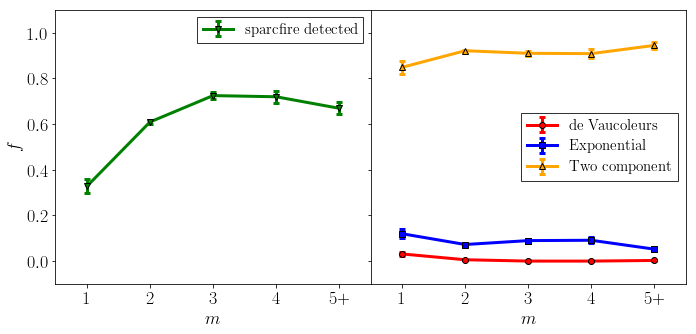

In [18]:
#mass_data = Table.read('fits/mendel_matched.fits')

# Type 1 = all bulge
# Type 2 = all disc
# Type 3 = bulge + disc

bins = gz2_stats['m'][in_ml][in_sparcfire]
types = mendel_data['Type'][in_ml][in_sparcfire]

colors = ('red','blue','orange')
labels = ('de Vaucoleurs','Exponential','Two component')
markers = 'os^'



fig, axarr = plt.subplots(1,2,figsize=(10,5),
                          sharex=True,sharey=True)

ax = axarr[0]
_ = ax.errorbar([1,2,3,4,5],f_sparcfire['f'],
                yerr=(f_sparcfire['f']-f_sparcfire['f-0.683']),
                color='g',marker='v',capsize=3,capthick=3,lw=3,
                markeredgecolor='k',
                label='sparcfire detected')
_ = ax.legend(fontsize=15,fancybox=False,edgecolor='k')

ax = axarr[1]

for type_, (color,label,marker) in enumerate(zip(colors,labels,markers)):
    has_feature = types == type_ + 1
    f = TableStats(has_feature,bins).fraction_with_feature()
    _ = ax.errorbar([1,2,3,4,5],f['f'],yerr=(f['f']-f['f-0.683']),
                    color=color,marker=marker,capsize=3,capthick=3,lw=3,
                    markeredgecolor='k',
                    label=label)

_ = ax.legend(loc='center right',edgecolor='k',fancybox=False,fontsize=15)

_ = axarr[0].set_xticks([1,2,3,4,5])
_ = axarr[0].set_xticklabels(mlabels)
_ = axarr[0].set_xlabel('$m$')
_ = axarr[0].set_ylabel('$f$')
_ = axarr[1].set_xlabel('$m$')
fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)

_ = ax.set_xlim(0.5,5.5)
_ = ax.set_ylim(-0.1,1.1)

In [19]:
# Now: correlate gz2 bulge statistics with those from Mendel+

bulge_classes = ['t05_bulge_prominence_a10_no_bulge_debiased_rh',
                 't05_bulge_prominence_a11_just_noticeable_debiased_rh',
                 't05_bulge_prominence_a12_obvious_debiased_rh',
                 't05_bulge_prominence_a13_dominant_debiased_rh']

bulge_array = np.array([gz2_data[c] for c in bulge_classes]).T

B = np.argmax(bulge_array,axis=1) + 1
B_wtd_avg = np.zeros(len(gz2_data))

for b, bulge_column in enumerate(bulge_classes):
    B_wtd_avg += (b+1)*gz2_data[bulge_column]
    
B_wtd_avg[np.isfinite(B_wtd_avg) == False] = 0

In [21]:
mendel_data['BTR'] = (10**mendel_data['logMb'])/10**mendel_data['bulge+disc']
mendel_data['BTR'][np.isfinite(mendel_data['BTR']) == False] = -999

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


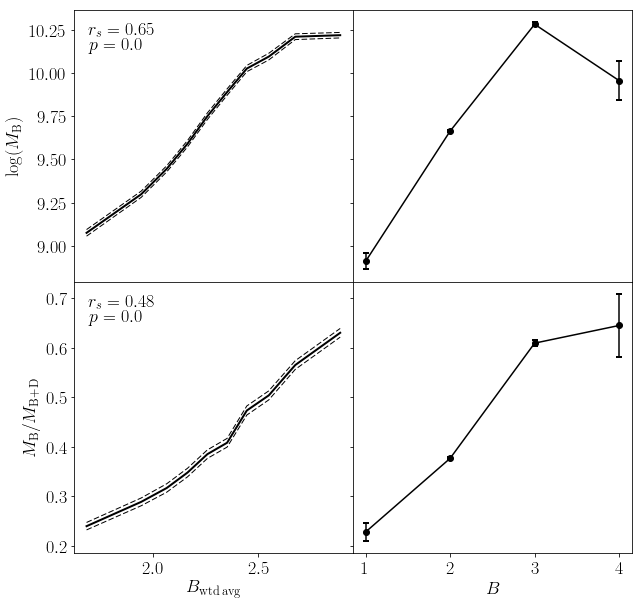

In [24]:
from xy_plots import x_vs_y

fig, axarr = plt.subplots(2,2,figsize=(10,10),
                          sharex='col',sharey='row')

fig.subplots_adjust(wspace=0,hspace=0)

sample_ok = ml_table_matched['vmax_ok']
x_s = [B_wtd_avg[sample_ok],B[sample_ok]]
y_s = [mendel_data['logMb'][sample_ok],mendel_data['BTR'][sample_ok]]


for y, y_ in enumerate(y_s):
    for x, x_ in enumerate(x_s):
        ax = axarr[y,x]
        xy = x_vs_y(x_,y_)
        if x == 0:
            xy = xy.continuous_vs_continuous_binned(equal_N=True)
            xy.line_plot(ax,lw=2,color='k')
            xy.error_plot(ax,style='lined',linestyle='dashed',
                          lw=1,color='k')
            xy.spearmanr(ax,location='upper left')
        else:
            xy = xy.discrete_vs_continuous_binned()
            xy.error_plot(ax,style='barred',color='k',marker='o',
                          capsize=3,capthick=2)
            

_ = axarr[0,0].set_ylabel('$\log(M_\mathrm{B})$')
_ = axarr[1,0].set_ylabel('$M_\mathrm{B}/M_\mathrm{B+D}$')
_ = axarr[1,0].set_xlabel('$B_\mathrm{wtd \, avg}$')
_ = axarr[1,1].set_xlabel('$B$')

#### See a very nice strong correlation b/w bulge mass and bulge prominence!

Now, As a final check, do the same for the four samples we've used before.

In [25]:
gz2_stats['p_bar'] = gz2_data['t03_bar_a06_bar_debiased_rh']
# define some classes:
# 1 = m=2, unbarred
# 2 = m=2, barred
# 3 = m>2, unbarred
# 4 = m>2, barred

plot_class = np.zeros(len(gz2_stats))
plot_class[(gz2_stats['m'] == 2) 
         & (gz2_stats['p_bar'] < 0.5)] = 1
plot_class[(gz2_stats['m'] == 2) 
         & (gz2_stats['p_bar'] >= 0.5)] = 2
plot_class[(gz2_stats['m'] > 2) 
         & (gz2_stats['p_bar'] < 0.5)] = 3
plot_class[(gz2_stats['m'] > 2) 
         & (gz2_stats['p_bar'] >= 0.5)] = 4

gz2_stats['plot_class'] = plot_class

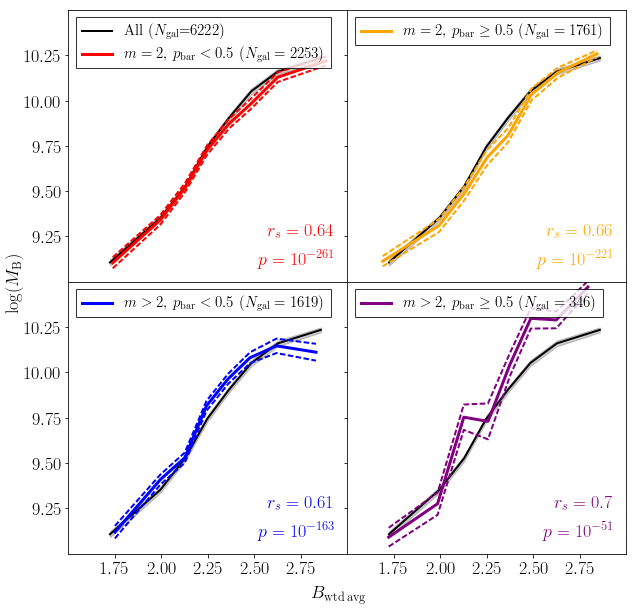

In [26]:
fig, axarr = plt.subplots(2,2,figsize=(10,10),
                          sharex=True,sharey=True)
axarr = axarr.ravel()
fig.subplots_adjust(wspace=0,hspace=0)

colors = ('r','orange','b','purple')
labels = ('$m=2$, $p_\mathrm{bar}<0.5$',
          '$m=2$, $p_\mathrm{bar} \geq 0.5$',
          '$m>2$, $p_\mathrm{bar} <0.5$',
          '$m>2$, $p_\mathrm{bar} \geq 0.5$')

x_all = B_wtd_avg[sample_ok]
y_all = mendel_data['logMb'][sample_ok]
all_bins = assign_bins(x_all,equal_N=True,N_bins=8)
all_classes = gz2_stats['plot_class'][sample_ok]
xy_all = x_vs_y(x_all,y_all)
xy_all = xy_all.continuous_vs_continuous_binned(bin_assignments=all_bins)

_ = axarr[0].plot([],[],'k-',lw=2,
                label='All ($N_\mathrm{{gal}}$={})'.format(len(x_all)))

for c, (ax,color,label) in enumerate(zip(axarr,colors,labels)):
    in_class = all_classes == c+1
    x_c = x_all[in_class]
    y_c = y_all[in_class]
    bins_c = all_bins[in_class]
    
    label = label + ' ($N_\mathrm{{gal}}={}$)'.format(in_class.sum())
    
    xy_all.line_plot(ax,color='k',lw=2)
    xy_all.error_plot(ax,color='k',alpha=0.2,style='filled')
    
    xy = x_vs_y(x_c,y_c)
    xy = xy.continuous_vs_continuous_binned(bin_assignments=bins_c)
    xy.line_plot(ax,lw=3,color=color,label=label)
    xy.error_plot(ax,style='lined',lw=2,color=color,linestyle='dashed')
    xy.spearmanr(ax,location='lower right',color=color,spacing=0.1)
    ax.legend(loc='upper left',edgecolor='k',fancybox=False,fontsize=15)
    
    
_ = fig.text(0.5, 0.06,'$B_\mathrm{wtd \, avg}$', ha='center')
_ = fig.text(0.04, 0.5,r'$\log(M_\mathrm{B})$', 
             va='center', rotation='vertical')

#_ = axarr[0].set_yticks([9,9.5,10,10.5])
_ = axarr[0].set_ylim(9,10.5)
_ = axarr[0].set_xlim(1.5,3)
_ = axarr[0].set_xticks(np.linspace(1.75,2.75,5))